In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Make matplotlib plots bigger
plt.rcParams['figure.figsize'] = [15, 9]

First we need a way to open raw images. We will use the `rawpy` library with such settings that minimal processing is done on the image. Only debayering to a 16-bit linear image.

In [18]:
import rawpy

def open_raw_image(path: str) -> np.ndarray:
    with rawpy.imread(path) as raw:
        return np.float32(raw.postprocess(output_bps=16, user_flip=0, gamma=(1.0, 1.0), user_wb=[1.0, 1.0, 1.0, 1.0], output_color=rawpy.ColorSpace.raw, no_auto_bright=True)) / 65535.0


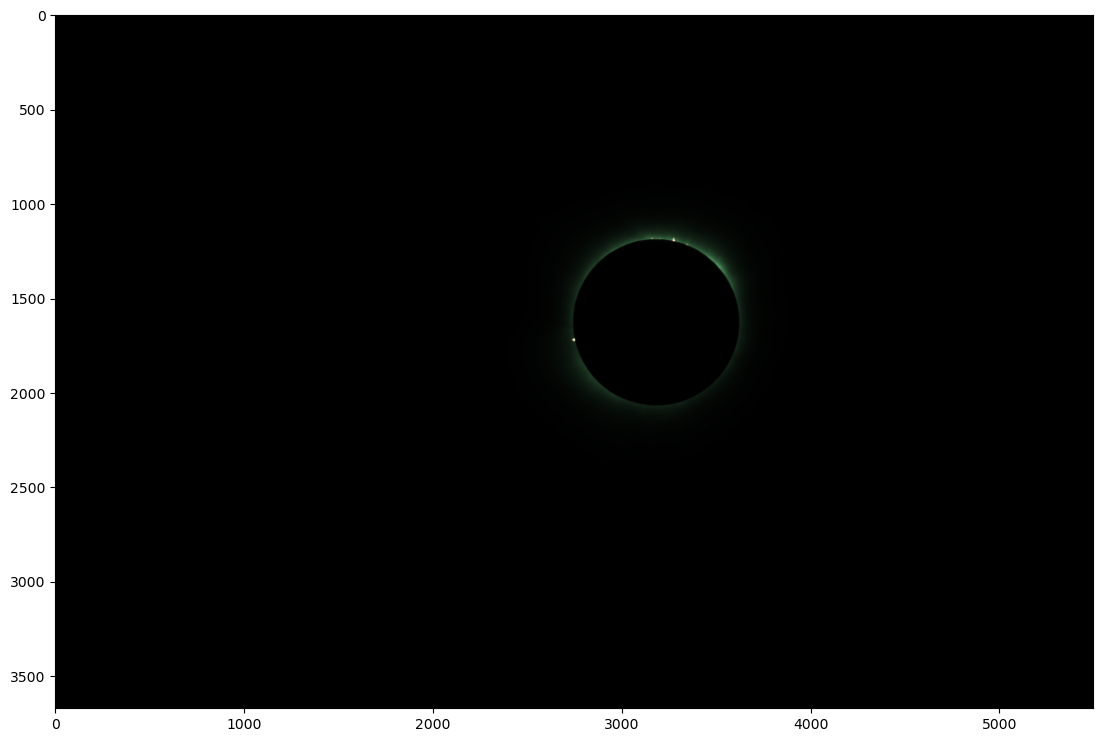

In [23]:
raw_image = open_raw_image(r'D:\Juttuja\EclipseAlignment\corona_images\7C0A4797.CR3')
plt.imshow(raw_image, vmin=0, vmax=1)

We must mask out the edges of the image. Otherwise they will contribute to the frequency contents of the image when it is run through Fast Fourier Transform (FFT). We use a 2-dimensional Hann window as a mask. It will smoothly fade to black towards all edges, eliminating the edge.

(3670, 5496)


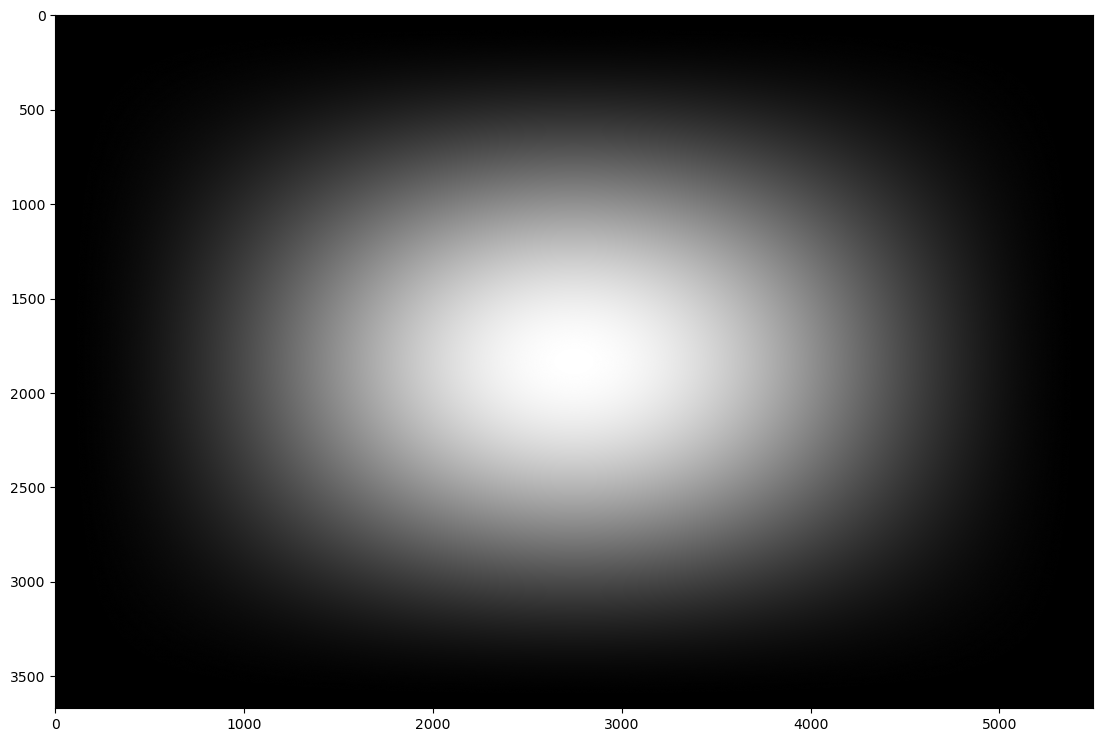

In [24]:
from scipy.signal.windows import hann

window = np.outer(hann(raw_image.shape[0]), hann(raw_image.shape[1]))
print(window.shape)
plt.imshow(window, cmap='gray', vmin=0, vmax=1)

Next we need to mask out the moon and the saturated part of the corona. To achieve this we must find the approximate center and radius of the moon in the image. We do this with the Hough Circle Transform from OpenCV.

Found circle: [3181.5 1621.5  435.6]


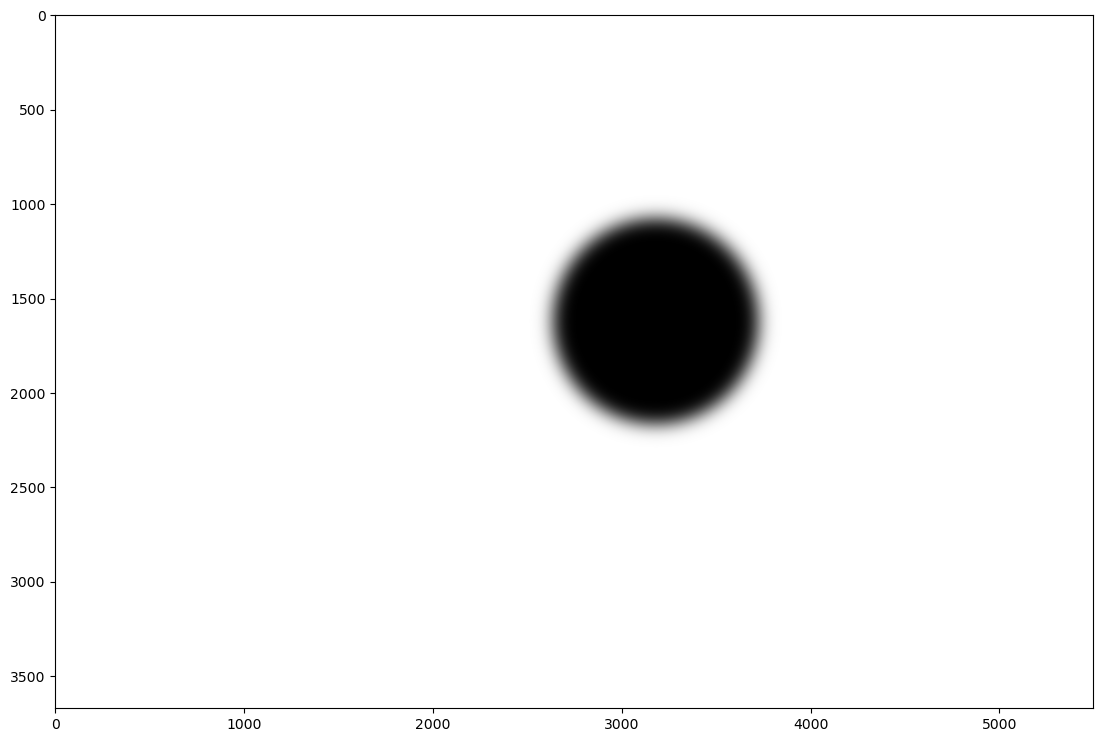

In [21]:
import cv2

def find_circle(image: np.ndarray, min_radius, max_radius) -> np.ndarray | None:
    image_8bit = (image * 255).astype(np.uint8)

    detected_circles = cv2.HoughCircles(image_8bit, cv2.HOUGH_GRADIENT, dp=3, minDist=image_8bit.shape[0]/16.0, param1=200, param2=100, minRadius=min_radius, maxRadius=max_radius)
    if detected_circles is not None:
        return detected_circles[0][0]
    else:
        return None

found_circle = find_circle(raw_image[:, :, 1], min_radius=300, max_radius=700)
print(f"Found circle: {found_circle}")
moon_mask = np.zeros_like(raw_image[:, :, 1])
r = found_circle[2]
x = found_circle[0]
y = found_circle[1]
moon_mask = 1 - cv2.circle(moon_mask, (int(x), int(y)), int(1.25 * r), 1, thickness=-1)
moon_mask = cv2.GaussianBlur(moon_mask, (0, 0), sigmaX=moon_mask.shape[0] / 80, sigmaY=moon_mask.shape[0] / 80)
plt.imshow(moon_mask, cmap='gray', vmin=0, vmax=1)

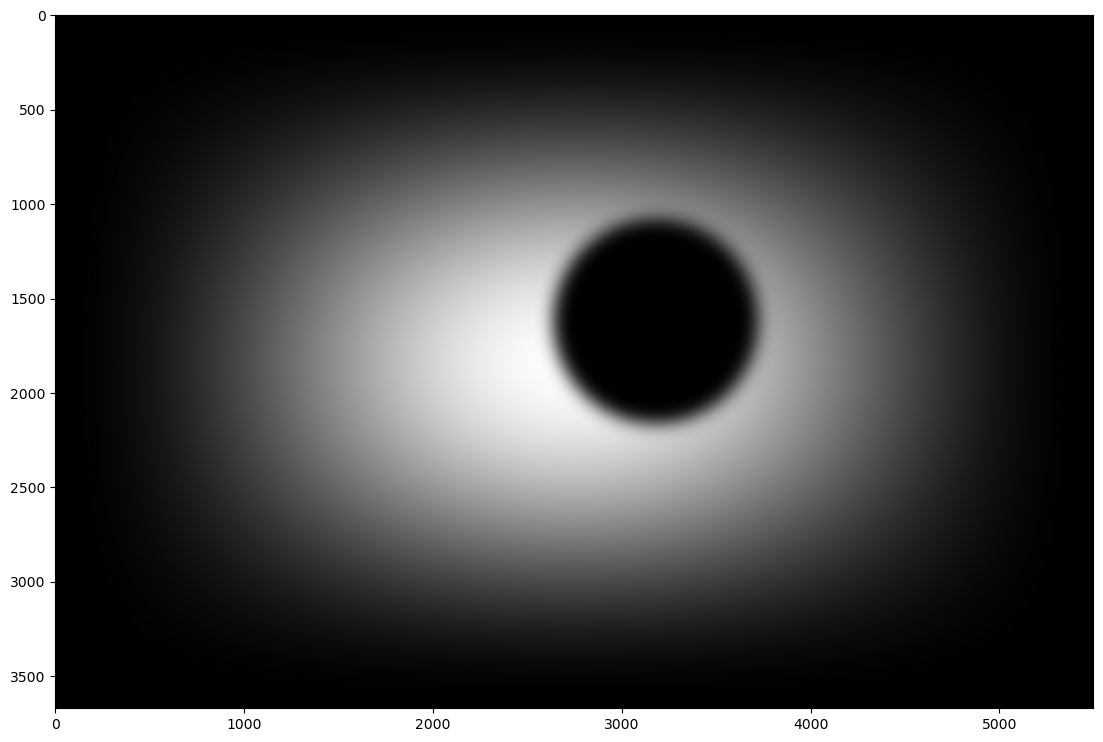

In [22]:
combined_mask = moon_mask * window
plt.imshow(moon_mask * window, cmap='gray', vmin=0, vmax=1)